In this homework you are going to rectify a document image that suffers 
from severe distortion. You will be using
the same image and the same detected corners from the previous lesson (lesson 6).

In [1]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

(<Axes: >, <matplotlib.image.AxesImage at 0x2654366ab70>)

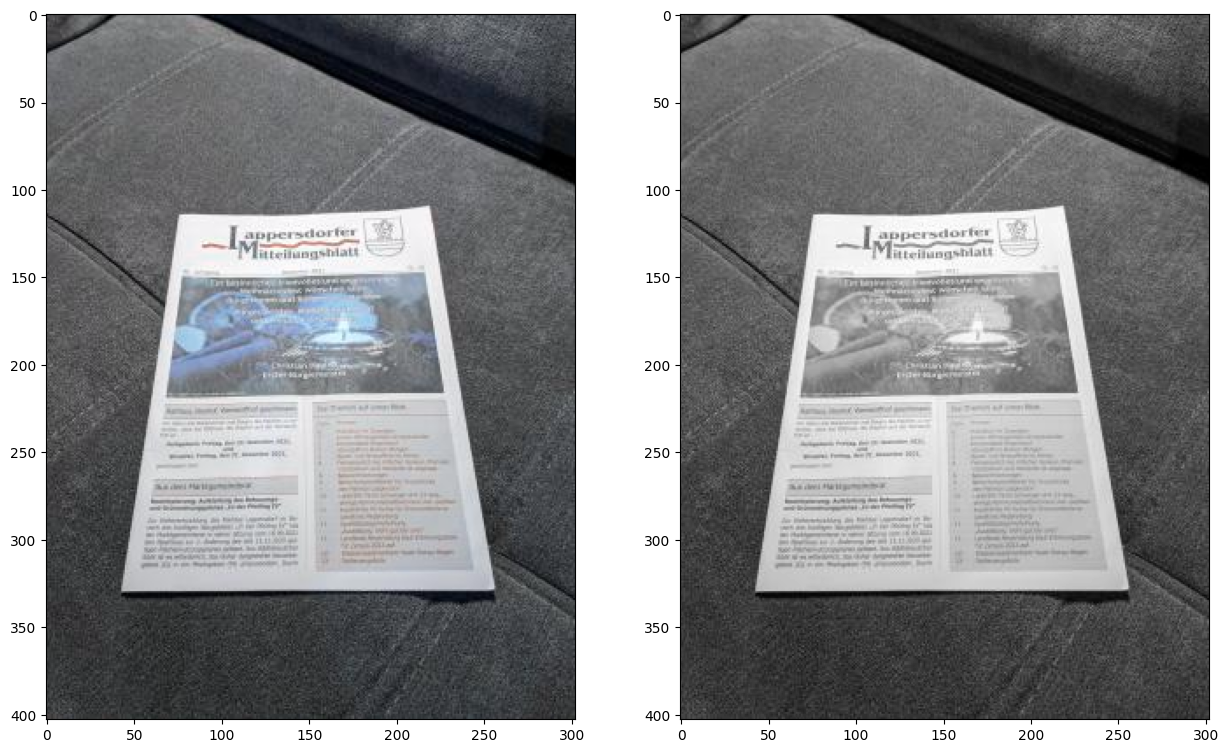

In [2]:
img = cv2.imread('../data/document.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)/255
rows, cols = gray.shape

# Let's plot the image
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(gray, cmap='gray')

In [3]:
top_left = [76, 115]
top_right = [219, 111]
bottom_left = [43, 330]
bottom_right = [256, 329]

(<Axes: >, <matplotlib.image.AxesImage at 0x265436ce2a0>)

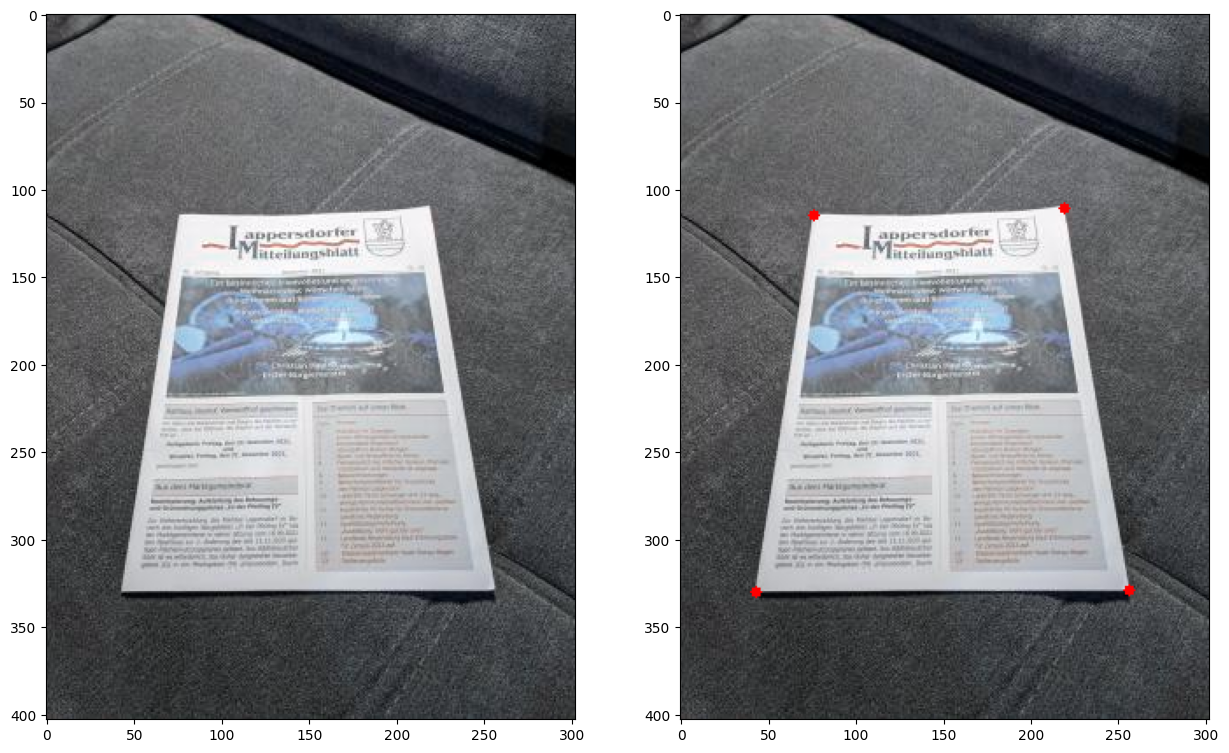

In [4]:
# Let's plot the points
out = np.copy(img)
out = cv2.circle(out, tuple(top_left), 3, (255,0,0), -1)
out = cv2.circle(out, tuple(top_right), 3, (255,0,0), -1)
out = cv2.circle(out, tuple(bottom_left), 3, (255,0,0), -1)
out = cv2.circle(out, tuple(bottom_right), 3, (255,0,0), -1)

plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(out)

Let's now try to rectify the document. The goal is to bring the four document corners to the image corners. For instance, we want the top-left document corner to become (0, 0), i.e., the top-left corner of the image itself. In that way, we will fill the complete image with document information and we will throw away parts of the images that correspond to background (which are of no use to us).

In [5]:
# Define the matrix of source points corresponding to the 4 document corners.
# The matrix shall have shape (4, 2), i.e., 4 corners x 2 coordinates
# Note: You will need to explicitly use float32 data type
src = np.array([
    top_left,      
    top_right,     
    bottom_right,  
    bottom_left    
], dtype=np.float32)

In [6]:
# Define the matrix of target (destination) points corresponding to the 4 image corners.
# The matrix shall have shape (4, 2), i.e., 4 corners x 2 coordinates
# Note: You will need to explicitly use float32 data type
# Note2: The order of points in src and dst must be the same
dst = np.array([
    [0, 0],                    # верхний левый угол
    [img.shape[1] - 1, 0],     # верхний правый угол
    [img.shape[1] - 1, img.shape[0] - 1],  # нижний правый угол
    [0, img.shape[0] - 1]      # нижний левый угол
], dtype=np.float32)

Let's first start with the affine transform for document rectification. The affine transform can be analytically calculated using 3 point pairs. Therefore, let's select the first 3 points and calculate the correspnding transfrom. We will then use the transform to rectify the document.

(<Axes: >, <matplotlib.image.AxesImage at 0x265438a6930>)

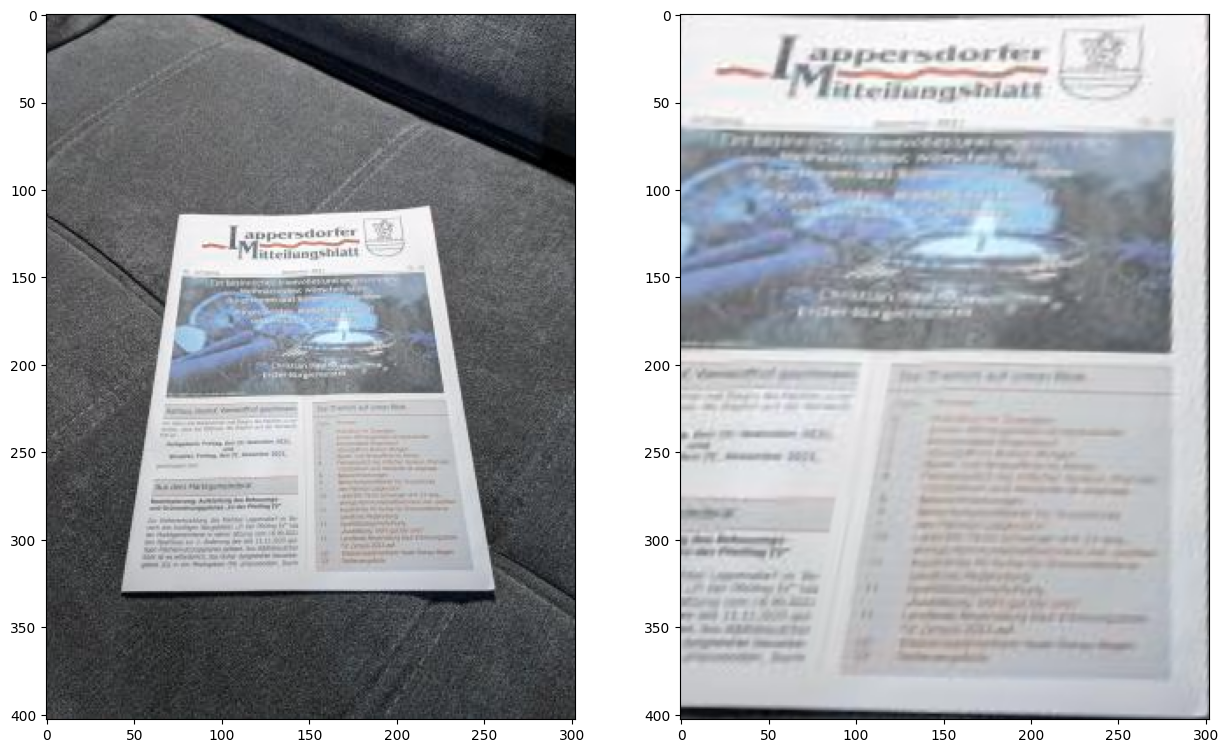

In [7]:
# Compute the affine transform matrix (you'll have to use getAffineTransform function from OpenCV here)
# Use the first 3 points from your src and dst matrix
M = cv2.getAffineTransform(src[:3], dst[:3])

# Build the rectified image using the computed matrix (you'll have to use warpAffine function from OpenCV here)
rectified = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(rectified)

(<Axes: >, <matplotlib.image.AxesImage at 0x26543d39d60>)

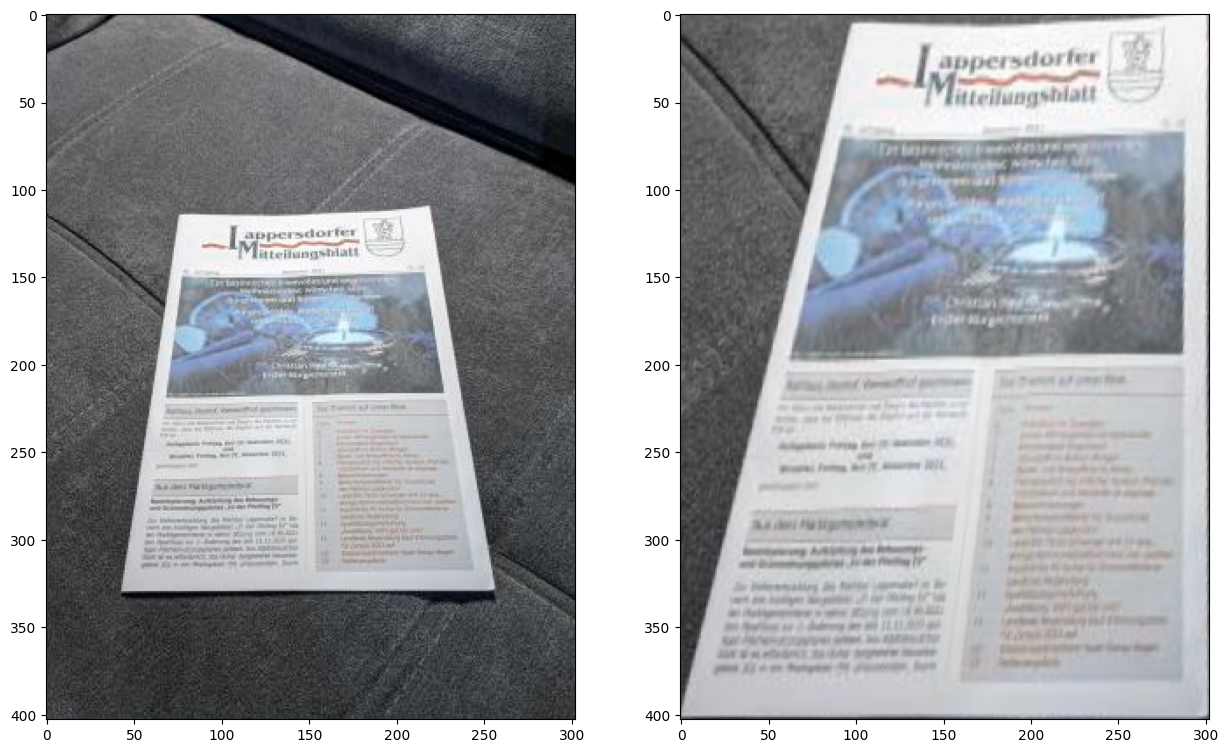

In [8]:
# Compute the affine transform matrix (use getAffineTransform)
# Use the last 3 points from your src and dst matrix
M = cv2.getAffineTransform(src[1:4], dst[1:4])

# Build the rectified image using the computed matrix (you'll have to use warpAffine function from OpenCV here)
rectified = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))

# Let's plot the results
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(rectified)

Вектор inliers: [[1]
 [1]
 [0]
 [1]]
Количество inliers: 3
Процент inliers: 75.00%


(<Axes: >, <matplotlib.image.AxesImage at 0x265436ce9c0>)

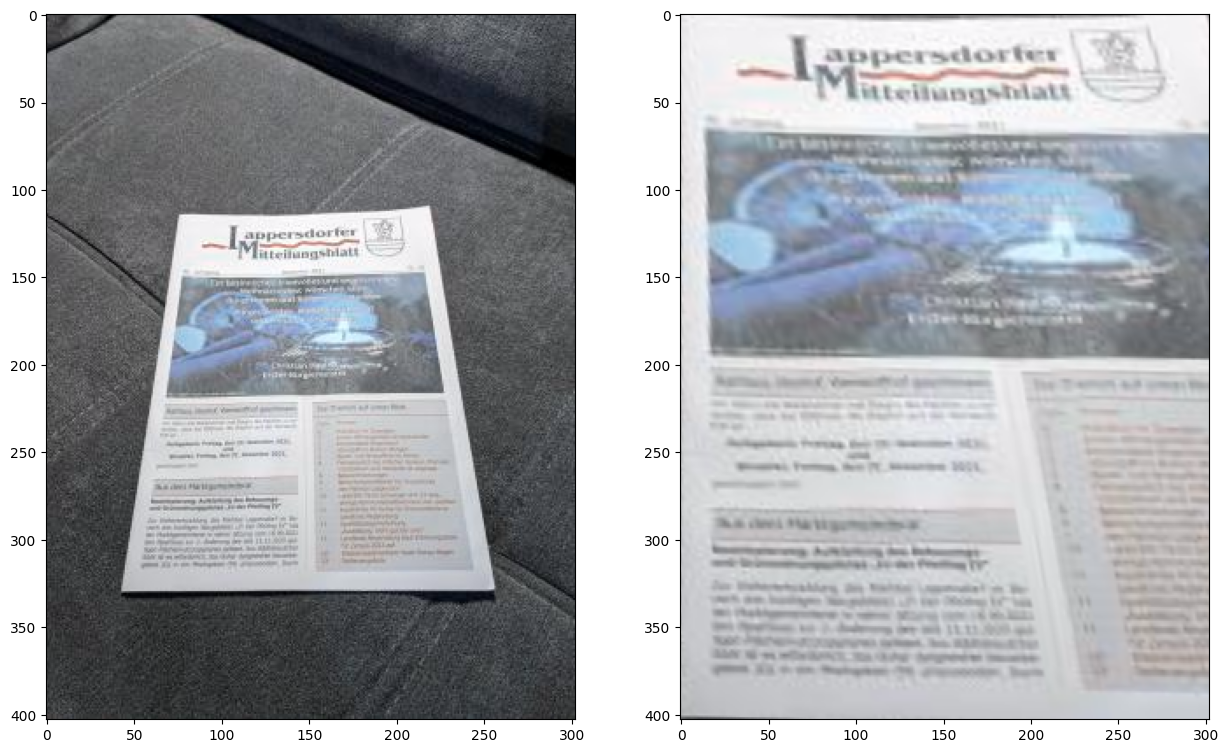

In [12]:
# Estimate the optimal affine transform matrix (you'll have to use estimateAffine2D function from OpenCV here)
# estimateAffine2D it returns the best fitting affine matrix as well as the vector of inliers (1 -> inlier,
# 0 -> outlier).
M, inliers = cv2.estimateAffine2D(src, dst)
print("Вектор inliers:", inliers)
print("Количество inliers:", np.sum(inliers))
print("Процент inliers: {:.2f}%".format(np.sum(inliers) / len(inliers) * 100))
# Build the rectified image using the computed matrix (use warpAffine)
rectified = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(rectified)

The result looks different but not better. This approach doesn't seem to be helping then. Let's use all 4 points and let OpenCV estimate (remember that 4 points are too many for an analytical solution) the best fitting affine transform for us. It'll internally apply optimization approaches as well as RANSAC.

There is not much of an improvement either. Let's try homography instead of affine transform. Remember that for computing the homography analytically we need to use 4 pairs of points.

(<Axes: >, <matplotlib.image.AxesImage at 0x26547721490>)

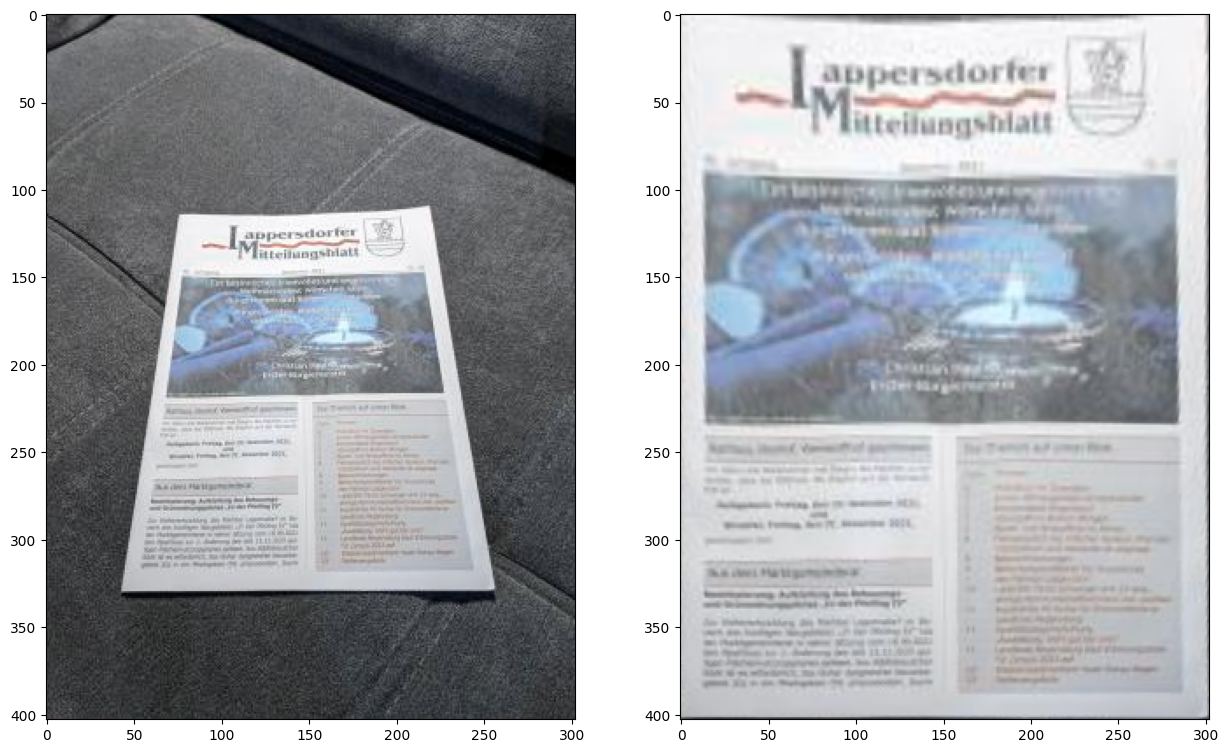

In [10]:
# Compute the homography matrix (you'll have to use getPerspectiveTransform function from OpenCV here)
M = cv2.getPerspectiveTransform(src, dst)

# Build the rectified image using the computed matrix (you'll have to use warpPerspective function from OpenCV)
rectified = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(rectified)

(<Axes: >, <matplotlib.image.AxesImage at 0x26547b34080>)

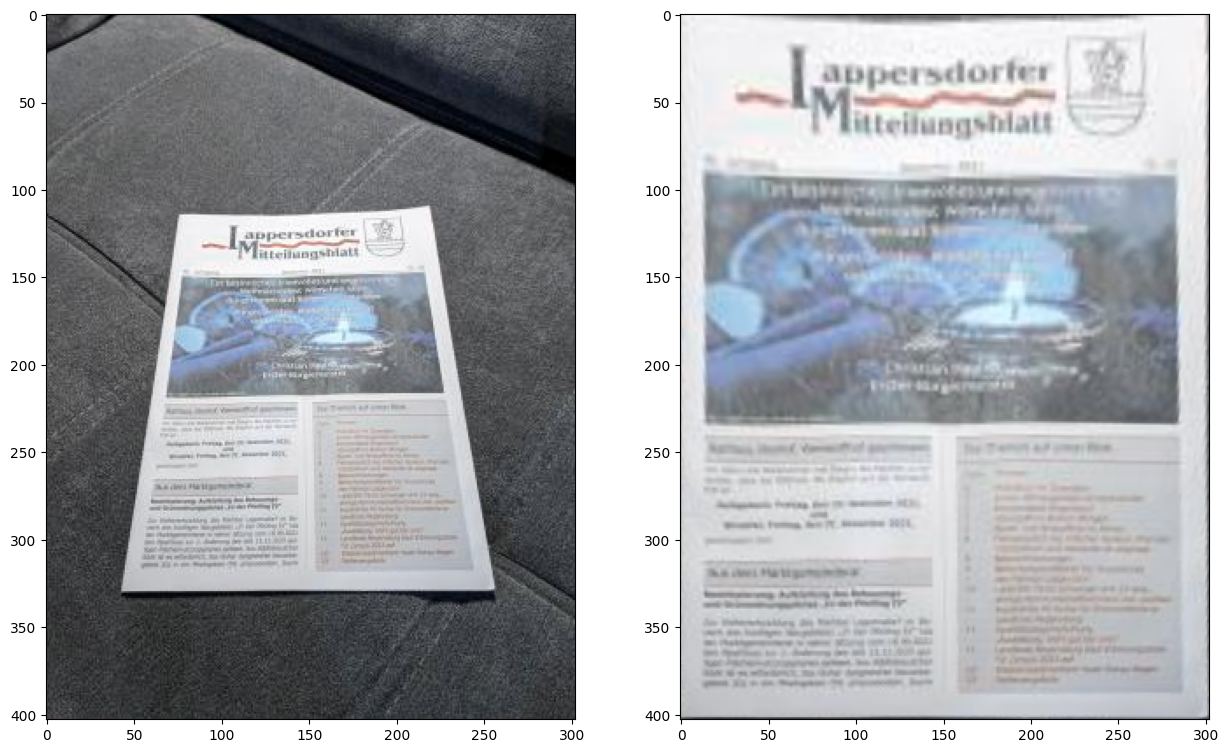

In [11]:
M, inliers = cv2.findHomography(src, dst)

# Build the rectified image using the computed matrix (you'll have to use warpPerspective function from OpenCV)
rectified = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(rectified)

The affine transform does not seem to be working well in this case. Why?
    Афинное преобразование не работает хорошо, потому что это линейное преобразование, 
    которое сохраняет  параллельность линий. 

What can you tell me about the values you have obtained for the inliers vector? What does it mean?
    Выбрали точки кроме правого нижнего угла, 
    из того насколько они вписываються в модель афинного преобразования: 
    Для каждой точки вычисляется  ошибка трансформации. Э
    то расстояние между фактическим положением точки и положением, предсказанным моделью.

How does the result from homography look? Does it work well enough?
    искажения еще присутствуют, но наверное это лучшее что можно ожидать от 4х точек.